In [12]:
import pandas as pd
import numpy as np
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
df = pd.read_csv('heart.csv')
df.columns = df.columns.str.strip()
df['Cholesterol'] = df['Cholesterol'].replace(0, np.nan)

X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorical_features = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
X['FastingBS'] = X['FastingBS'].astype(str)

In [14]:
numeric_transformer_nb = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_transformer_nb = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))
])
preprocessor_nb = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_nb, numerical_features),
        ('cat', categorical_transformer_nb, categorical_features)
    ],
    remainder='passthrough'
)




In [15]:
X_processed_nb = preprocessor_nb.fit_transform(X)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_processed_nb, y, test_size=0.2, random_state=42, stratify=y)
print(f"Dados divididos em {X_train.shape[0]} amostras de treino e {X_test.shape[0]} de teste.\n")

Dados divididos em 734 amostras de treino e 184 de teste.



In [17]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

GaussianNB()

In [18]:
y_pred_nb = nb_model.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb)

print("- Métricas de Avaliação do Modelo Naive Bayes")
print(f"Acurácia: {accuracy_nb:.4f}")
print(f"Precision: {precision_nb:.4f}")
print(f"Recall (: {recall_nb:.4f}")
print(f"F1: {f1_nb:.4f}\n")

print("- Relatório de Classificação")
print(classification_report(y_test, y_pred_nb, target_names=['Não Doente (0)', 'Doente (1)']))


- Métricas de Avaliação do Modelo Naive Bayes
Acurácia: 0.8641
Precision: 0.8812
Recall (: 0.8725
F1: 0.8768

- Relatório de Classificação
                precision    recall  f1-score   support

Não Doente (0)       0.84      0.85      0.85        82
    Doente (1)       0.88      0.87      0.88       102

      accuracy                           0.86       184
     macro avg       0.86      0.86      0.86       184
  weighted avg       0.86      0.86      0.86       184



- Matriz de Confusão


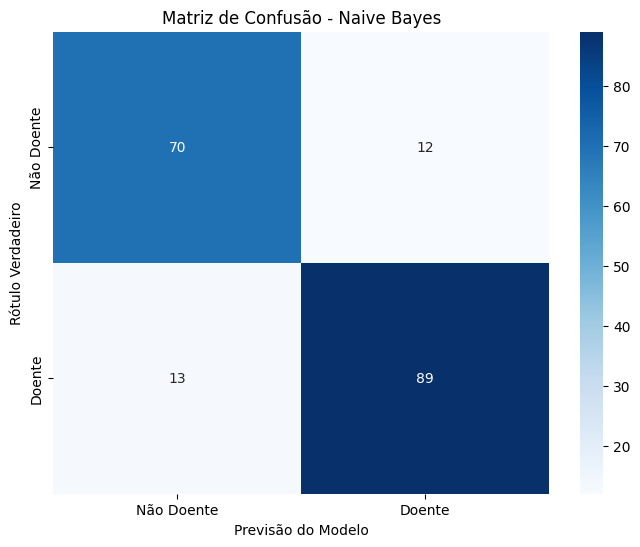

In [19]:
print("- Matriz de Confusão")
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Não Doente', 'Doente'], 
            yticklabels=['Não Doente', 'Doente'])
            
plt.xlabel('Previsão do Modelo')
plt.ylabel('Rótulo Verdadeiro')
plt.title('Matriz de Confusão - Naive Bayes')
plt.show()

In [20]:
numeric_features = preprocessor_nb.transformers_[0][2]
categorical_features_transformed = preprocessor_nb.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
final_feature_names = numeric_features + list(categorical_features_transformed)

means_class_0 = nb_model.theta_[0]
means_class_1 = nb_model.theta_[1]
vars_class_0 = nb_model.var_[0]
vars_class_1 = nb_model.var_[1]

df_interpret = pd.DataFrame({
    'Feature': final_feature_names,
    'Media_Nao_Doente (Classe 0)': means_class_0,
    'Media_Doente (Classe 1)': means_class_1,
    'Variancia_Nao_Doente (Classe 0)': vars_class_0,
    'Variancia_Doente (Classe 1)': vars_class_1
})

df_interpret = df_interpret.set_index('Feature')
print("--- Perfil Estatístico Aprendido pelo Naive Bayes ---")
display(df_interpret.round(3))

--- Perfil Estatístico Aprendido pelo Naive Bayes ---


,Media_Nao_Doente (Classe 0),Media_Doente (Classe 1),Variancia_Nao_Doente (Classe 0),Variancia_Doente (Classe 1)
Feature,,,,
Age,-0.237,0.256,1.004,0.891
RestingBP,-0.085,0.115,0.815,1.047
Cholesterol,-0.049,0.093,1.106,0.962
MaxHR,0.443,-0.388,0.817,0.892
Oldpeak,-0.436,0.315,0.472,1.142
Sex_ M,0.662,0.892,0.224,0.097
ChestPainType_ ASY,0.262,0.781,0.193,0.171
ChestPainType_ ATA,0.357,0.047,0.229,0.045
ChestPainType_ NAP,0.314,0.128,0.215,0.112


Analisar: ST_Slope_UP, OldPeak, MaxHR, ST_Slope_Flat, ....
essas deram bastante diferença na média de doentes e não doentes

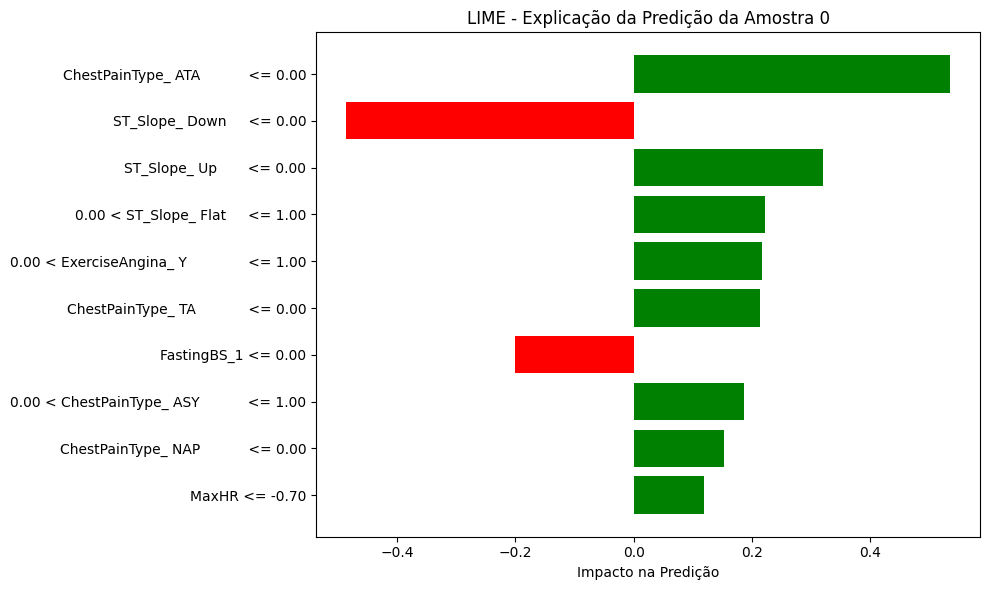

In [ ]:
explainer_nb = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=final_feature_names,
    class_names=['Não Doente', 'Doente'],
    mode='classification'
)
idx = 0
exp = explainer_nb.explain_instance(
    data_row=X_test[idx],
    predict_fn=nb_model.predict_proba
)

lime_list = exp.as_list()
features = [x[0] for x in lime_list]
impacts = [x[1] for x in lime_list]

plt.figure(figsize=(10, 6))
colors = ['green' if val > 0 else 'red' for val in impacts]  z
plt.barh(features, impacts, color=colors)
plt.xlabel('Impacto na Predição')
plt.title(f'LIME - Explicação da Predição da Amostra {idx}')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()

In [ ]:
perm_importance = permutation_importance(
    nb_model, X_test, y_test,
    n_repeats=30,  
    random_state=42,
    scoring='accuracy'
)

df_perm = pd.DataFrame({
    'Feature': final_feature_names,
    'Importance_Mean': perm_importance.importances_mean,
    'Importance_Std': perm_importance.importances_std
}).sort_values(by='Importance_Mean', ascending=False)

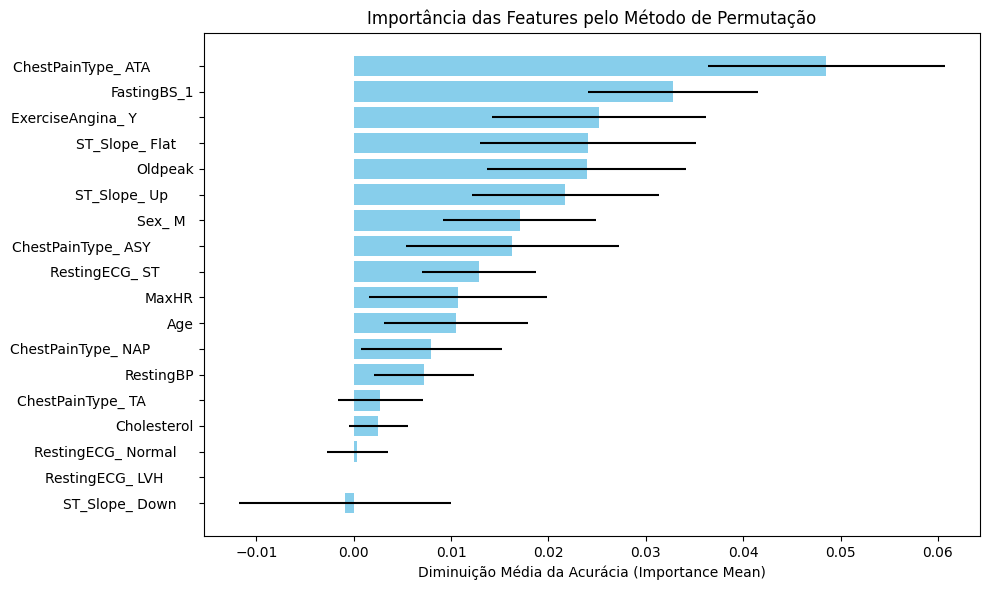

In [25]:
df_perm_sorted = df_perm.sort_values(by='Importance_Mean', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(df_perm_sorted['Feature'], df_perm_sorted['Importance_Mean'],
         xerr=df_perm_sorted['Importance_Std'], color='skyblue')
plt.xlabel('Diminuição Média da Acurácia (Importance Mean)')
plt.title('Importância das Features pelo Método de Permutação')
plt.tight_layout()
plt.show()